In [7]:
import sys
import glob
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

nc_path = '/Users/research/Documents/GitHub/gliderProcessing/glider_data/echo_20230113/delayed/nc/'
processing_mode = 'delayed'

files = sorted(glob.glob(nc_path + '*{}*.nc'.format(processing_mode)))
data_list = []
glider_record_list = []

for f in files:
    try:
        tmpData = xr.open_dataset(f, engine='netcdf4', decode_times=False)
        data_list.append(tmpData)
        tmpGliderRecordData = xr.open_dataset(f, engine='netcdf4', group='glider_record', decode_times=False)
        glider_record_list.append(tmpGliderRecordData)
        print('Processed {}'.format(f))
    except Exception as e:
        print('Ignore {}. Error: {}'.format(f, e))

raw_data = xr.concat(glider_record_list, dim='time').sortby('time')
data = xr.concat(data_list, dim='time').sortby('time')

# Convert xarray datasets to pandas dataframes
raw_data = raw_data.to_dataframe().reset_index()
data = data.to_dataframe().reset_index()

Processed /Users/research/Documents/GitHub/gliderProcessing/glider_data/echo_20230113/delayed/nc/echo-2023-012-0-0_delayed.nc
Processed /Users/research/Documents/GitHub/gliderProcessing/glider_data/echo_20230113/delayed/nc/echo-2023-012-1-0_delayed.nc
Processed /Users/research/Documents/GitHub/gliderProcessing/glider_data/echo_20230113/delayed/nc/echo-2023-012-2-0_delayed.nc
Processed /Users/research/Documents/GitHub/gliderProcessing/glider_data/echo_20230113/delayed/nc/echo-2023-012-2-1_delayed.nc
Processed /Users/research/Documents/GitHub/gliderProcessing/glider_data/echo_20230113/delayed/nc/echo-2023-012-2-2_delayed.nc
Processed /Users/research/Documents/GitHub/gliderProcessing/glider_data/echo_20230113/delayed/nc/echo-2023-012-3-0_delayed.nc


## Correct lon/lat dead reckoning

In [8]:
# Path containing python functions
path = ['/Users/research/Documents/GitHub/gliderProcessing/glider_processing_scripts/']
sys.path.append(path[0])

from gliderfuncs import correct_dead_reckoning, findProfiles

data['lon_qc'],data['lat_qc'] = correct_dead_reckoning(raw_data['m_lon'],raw_data['m_lat'],raw_data['time'],raw_data['x_dr_state'],raw_data['m_gps_lon'],raw_data['m_gps_lat'])


## Find Profiles

In [9]:
data['profile_index'],data['profile_direction']=findProfiles(data['time'],data['depth'],stall=20,shake=200)

## Data QC

In [10]:
from quartod_qc import quartod_qc_checks

done: test 1 - range check test for variable salinity
done: test 2 - spike test for variable salinity
done: test 3 - rate of change test for variable salinity
done: test 4 - flat line test for variable salinity


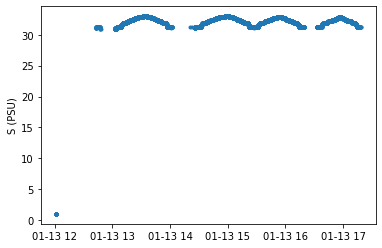

In [15]:
qc_options = {
    'sensor_min': 10,
    'sensor_max': 40,
    'sensor_user_min': 10,
    'sensor_user_max': 40,
    'spike_thrshld_low': 3,
    'spike_thrshld_high': 5,
    'n_dev': 1,          # Adjust this value to represent the max acceptable rate of change
    'time_dev': 20/3600, # Set to the upper bound of the time range you're interested in (60 seconds)
    'min_wind_size': 20,
    'eps': 1e-6,
    'rep_cnt_fail': 2,
    'rep_cnt_suspect': 4
}

salinity_qc_flag = quartod_qc_checks(data['salinity'].values, data['time'].values, 'salinity',qc_options)

data['salinity_qc'] = data['salinity'].copy()
data['salinity_qc'][salinity_qc_flag !=1] = np.nan


# Plot
plt.plot(np.array(data['time'], dtype='datetime64'), data['salinity'],'.')
#plt.plot(np.array(data['time'], dtype='datetime64'), data['salinity_qc'], '.')
plt.ylabel('S (PSU)')
#plt.ylim(np.nanmin(data['salinity_qc']),np.nanmax(data['salinity_qc']))
plt.show()

In [ ]:
'''
from data2attr import save_netcdf
fname='echo-trajectory_file.nc'
gliders_db = '/Users/research/Documents/GitHub/gliderProcessing/glider_reference_information/glider_serial-numbers_and_sensor-serial-numbers.csv'
metadata_source = '/Users/research/Documents/GitHub/gliderProcessing/glider_data/echo_20230113/metadata.yml'
encoder = '/Users/research/Documents/GitHub/gliderProcessing/glider_processing_scripts/attributes/glider_dac_3.0_conventions.yml'

source_info = {
    'gliders_db': gliders_db,
    'metadata_source': metadata_source,
    'encoder': encoder,
    'processing_mode': 'delayed',
    'data_type': 'trajectory',
    'data_source': files,
    'filename': fname,
    'filepath': nc_path
}

save_netcdf(data, raw_data,source_info)

# Check result
traj_file_name = sorted(glob.glob(nc_path + '*{}*.nc'.format('trajectory')))
traj_data = xr.open_dataset(traj_file_name[0], engine='netcdf4', decode_times=False)

traj_data
'''


## PLOTS

In [ ]:
'''

fig, ax = plt.subplots(figsize=(14,7))
plt.plot(data['time'],data['depth'])
plt.gca().invert_yaxis()
ax.set(xlabel='time', ylabel='depth(m)',
       title='Glider Dives')


fig, ax = plt.subplots(figsize=(14,7))
idx_down = np.flatnonzero(data['profile_index'] == 1)
idx_up = np.flatnonzero(data['profile_index'] == 2)
ax.plot(data['time'].values[idx_down], data['depth'].values[idx_down], 'o', label='down cast')
ax.plot(data['time'].values[idx_up], data['depth'].values[idx_up], 'o', label='up cast')
ax.set(xlabel='time (s)', ylabel='depth (m)',
       title='Algorithm for Profile Splitting Code')
plt.gca().invert_yaxis()
ax.grid()
ax.legend()
plt.show()


fig, ax = plt.subplots(figsize=(14,7))
ax.plot(data['lon_qc'],data['lat_qc'],'o',label='corrected(underwater)')
ax.plot(raw_data['m_gps_lon'],raw_data['m_gps_lat'],'o',label='GPS(surface)')
ax.set(xlabel='longitude', ylabel='latitude',
       title='Algorithm for Deadreckoning Position Correction')
ax.grid()
ax.legend()
plt.show()


'''

